# Least Squares example


In [2]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import statFunctions
import thinkplot

## Least squares

One more time, let's load up the NSFG data.

In [6]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_kg

The following function computes the intercept and slope of the least squares fit.

In [7]:
from statFunctions import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

Here's the least squares fit to birth weight as a function of mother's age.

In [8]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(3.0982196357245697, 0.0079169432699525335)

The intercept is often easier to interpret if we evaluate it at the mean of the independent variable.

In [9]:
inter + slope * 25

3.2961432174733831

And the slope is easier to interpret if we express it in kg per decade.

In [10]:
slope * 10

0.079169432699525338

The following function evaluates the fitted line at the given `xs`.

In [11]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

And here's an example.

In [12]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

Here's a scatterplot of the data with the fitted line.

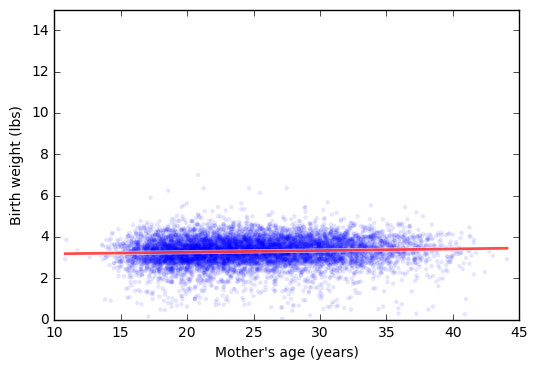

In [13]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

## Residuals

The following functon computes the residuals.

In [14]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

Now we can add the residuals as a column in the DataFrame.

In [15]:
live['residual'] = Residuals(ages, weights, inter, slope)

To visualize the residuals, I'll split the respondents into groups by age, then plot the percentiles of the residuals versus the average age in each group.

First I'll make the groups and compute the average age in each group.

In [16]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

Next I'll compute the CDF of the residuals in each group.

In [18]:
cdfs = [statFunctions.Cdf(group.residual) for _, group in groups][1:-1]

The following function plots percentiles of the residuals against the average age in each group.

In [19]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

The following figure shows the 25th, 50th, and 75th percentiles.

Curvature in the residuals suggests a non-linear relationship.

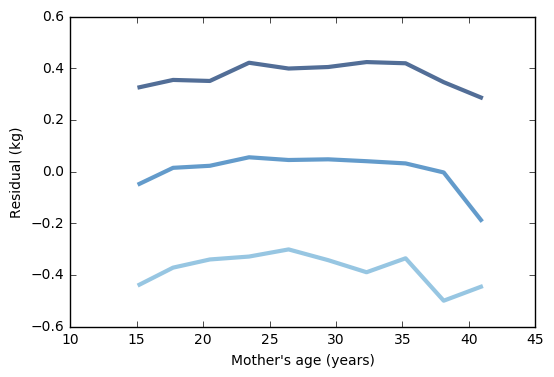

In [20]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (kg)',
                 xlim=[10, 45])

## Sampling distribution

To estimate the sampling distribution of `inter` and `slope`, I'll use resampling.

In [21]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

The following function resamples the given dataframe and returns lists of estimates for `inter` and `slope`.

In [22]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

Here's an example.

In [23]:
inters, slopes = SamplingDistributions(live, iters=1001)

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [26]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = statFunctions.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Here's  the summary for `inter`.

In [27]:
Summarize(inters)

mean, SE, CI 6.83002954694 0.07396770739362242 (6.7116423785714359, 6.9565303634376763)


And for `slope`.

In [28]:
Summarize(slopes)

mean, SE, CI 0.0174533601212 0.002902737300650678 (0.012451271523847446, 0.022093408214926967)


Generating a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [29]:
# Solution

iters = 1000
estimates = [ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.26567337907 0.014752629740085583 (7.2421926864350521, 7.2901291768090282)


## Visualizing uncertainty

To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

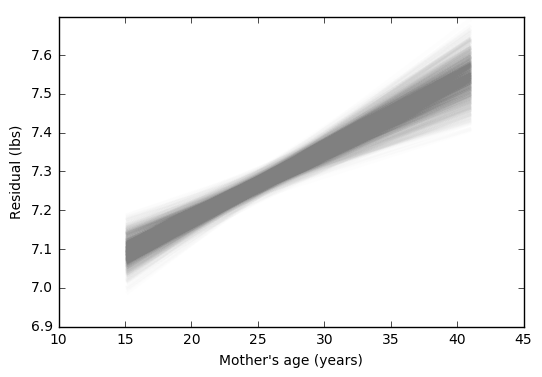

In [31]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

In [34]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = statFunctions.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

This example shows the confidence interval for the fitted values at each mother's age.

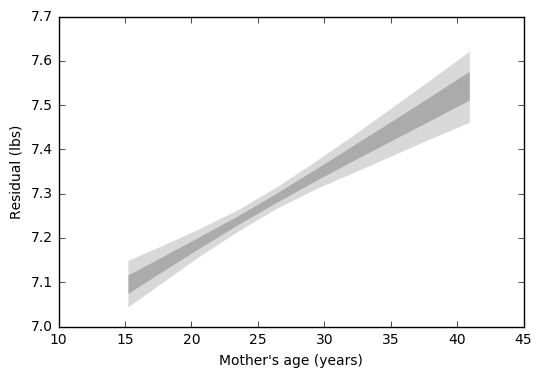

In [35]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## Coefficient of determination



The coefficient compares the variance of the residuals to the variance of the dependent variable.

In [36]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

For birth weight and mother's age $R^2$ is very small, indicating that the mother's age predicts a small part of the variance in birth weight.

In [37]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.0047381154747101473

We can confirm that $R^2 = \rho^2$:

In [39]:
print('rho', statFunctions.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.0688339703541
R 0.0688339703541


To express predictive power, I think it's useful to compare the standard deviation of the residuals to the standard deviation of the dependent variable, as a measure RMSE if you try to guess birth weight with and without taking into account mother's age.

In [40]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 0.6387565811072293
Std(res) 0.6372415331375854


As another example of the same idea, here's how much we can improve guesses about IQ if we know someone's SAT scores.

In [41]:
var_ys = 15**2
rho = 0.72
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

## Hypothesis testing with slopes

Here's a `HypothesisTest` that uses permutation to test whether the observed slope is statistically significant.

In [44]:
class SlopeTest(statFunctions.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = statFunctions.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

And it is.

In [45]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

Under the null hypothesis, the largest slope we observe after 1000 tries is substantially less than the observed value.

In [46]:
ht.actual, ht.MaxTestStat()

(0.0079169432699525335, 0.0038117625209064536)

We can also use resampling to estimate the sampling distribution of the slope.

In [47]:
sampling_cdf = statFunctions.Cdf(slopes)

The distribution of slopes under the null hypothesis, and the sampling distribution of the slope under resampling, have the same shape, but one has mean at 0 and the other has mean at the observed slope.

To compute a p-value, we can count how often the estimated slope under the null hypothesis exceeds the observed slope, or how often the estimated slope under resampling falls below 0.

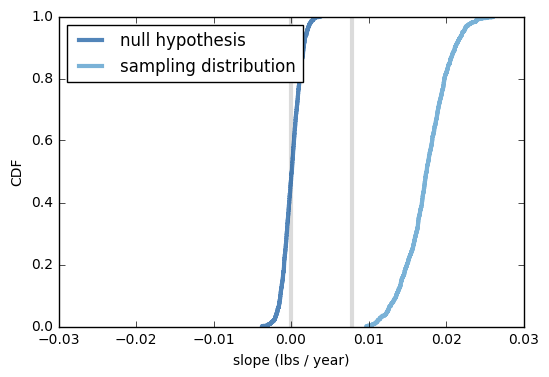

In [48]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

Here's how to get a p-value from the sampling distribution.

In [49]:
pvalue = sampling_cdf[0]
pvalue

0.0

## Resampling with weights

Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.

The following function resamples rows with probabilities proportional to weights.

In [37]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

We can use it to estimate the mean birthweight and compute SE and CI.

In [38]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.34774416353 0.0142502443955 (7.3235298185439257, 7.3702630559858378)


And here's what the same calculation looks like if we ignore the weights.

In [39]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.26579003928 0.0148174608611 (7.2415979752157558, 7.2900738548351409)


The difference is non-negligible, which suggests that there are differences in birth weight between the strata in the survey.